In [1]:
!pip install PyDrive
!pip install gensim
!pip install pyldavis
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=c9a8c72500dd3034a6a2e15171e1d2fa4a6df74fbfb9b36a35b2b12ff1828999
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=20961179eef3e03f1f4d930e10bdebc03eac7c60c2de9094ad5509a92b8af2b8
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import json
import re
import spacy
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
nltk.download('stopwords')

import seaborn as sns
import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
zf = zipfile.ZipFile('tripadvisor_hotel_reviews.zip') 
df = pd.read_csv(zf.open('tripadvisor_hotel_reviews.csv'))

In [6]:
df.shape

(20491, 2)

In [7]:
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from string import punctuation

In [10]:
def frequent_words(words, terms = 20):
  words_all = ' '.join([text for text in words])
  words_all = words_all.split()
  
  fdist = FreqDist(words_all)
  df_words = pd.DataFrame({'word':list(fdist.keys()), 'total':list(fdist.values())})
  
  # selecting top 30 most frequent words
  dfreq = df_words.nlargest(columns="total", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=dfreq, x= "word", y = "total")
  ax.set(ylabel = 'Count')
  plt.show()

In [11]:
# function to remove stopwords
def stopwords_rem(rev):
  rev_new = " ".join([i for i in rev if i not in (stop_words+list(punctuation))])
  return rev_new

In [12]:
nlp = spacy.load('en_core_web_sm')

In [13]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [14]:
# remove short words (length < 3)
df['Review'] = df['Review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [stopwords_rem(r.split()) for r in df['Review']]

# remove punctuation from the text
#reviews = [punctuation_rem(r.split()) for r in df['Review']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

In [15]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())

In [16]:
print(tokenized_reviews[1])
len(tokenized_reviews[1])

['nothing', 'special', 'charge', 'diamond', 'member', 'hilton', 'decided', 'chain', 'shot', '20th', 'anniversary', 'seattle,', 'start', 'booked', 'suite', 'paid', 'extra', 'website', 'description', 'not,', 'suite', 'bedroom', 'bathroom', 'standard', 'hotel', 'room,', 'took', 'printed', 'reservation', 'desk', 'showed', 'said', 'things', 'like', 'couch', 'ect', 'desk', 'clerk', 'told', 'mixed', 'suites', 'description', 'kimpton', 'website', 'sorry', 'free', 'breakfast,', 'got', 'kidding,', 'embassy', 'suits', 'sitting', 'room', 'bathroom', 'bedroom', 'unlike', 'kimpton', 'calls', 'suite,', 'day', 'stay', 'offer', 'correct', 'false', 'advertising,', 'send', 'kimpton', 'preferred', 'guest', 'website', 'email', 'asking', 'failure', 'provide', 'suite', 'advertised', 'website', 'reservation', 'description', 'furnished', 'hard', 'copy', 'reservation', 'printout', 'website', 'desk', 'manager', 'duty', 'crime', 'reply', 'solution,', 'send', 'email', 'trip', 'guest', 'survey', 'crime', 'follow', 

232

In [17]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['special', 'charge', 'diamond', 'member', 'chain', '20th', 'anniversary', 'seattle', 'suite', 'extra', 'website', 'description', 'bedroom', 'bathroom', 'standard', 'hotel', 'room', 'reservation', 'desk', 'thing', 'couch', 'ect', 'desk', 'clerk', 'mixed', 'suite', 'website', 'free', 'breakfast', 'embassy', 'suit', 'room', 'bathroom', 'bedroom', 'call', 'suite', 'day', 'stay', 'offer', 'false', 'advertising', 'guest', 'website', 'email', 'failure', 'suite', 'advertised', 'website', 'reservation', 'description', 'hard', 'copy', 'reservation', 'printout', 'website', 'desk', 'manager', 'duty', 'crime', 'reply', 'solution', 'email', 'trip', 'guest', 'survey', 'crime', 'follow', 'email', 'mail', 'staff', 'helpful', 'desk', 'good', 'breakfast', 'spot', 'neighborhood', 'hood', 'police', 'hotel', 'good', 'breakfast', 'spot', 'seattle', 'block', 'convenient', 'hotel', 'know', 'late', 'night', 'run', 'bellman', 'busy', 'cell', 'phone', 'help', 'arrival', 'hotel', 'inform', '20th', 'anniversary', 

In [18]:
set(tokenized_reviews[1]) - set(reviews_2[1])

{'1/2',
 'ac-heat',
 'advertising,',
 'arrived',
 'asked',
 'asking',
 'away',
 'bags.prior',
 'beds',
 'best',
 'better',
 'booked',
 'breakfast,',
 'bring',
 'building',
 'calls',
 'celebrate,',
 'chating',
 'cleaner',
 'comfortable.not',
 'concerned',
 'correct',
 'covered',
 'decided',
 'deliver',
 'directly',
 'emailed',
 'exist,',
 'eyes',
 'furnished',
 'gee',
 'good,',
 'got',
 'guess',
 'guest.the',
 'helpful,',
 'hilton',
 'hotels',
 'hotels,',
 'hours,',
 'indifferent',
 'inside',
 'kidding,',
 'kimpton',
 'like',
 'mail,',
 'make',
 'night,',
 'not,',
 'nothing',
 'paid',
 'pillows',
 'pillows,',
 'preferred',
 'printed',
 'property,',
 'provide',
 'ranged',
 'rates,',
 'really',
 'room,',
 'said',
 'saying',
 'seattle,',
 'send',
 'shot',
 'showed',
 'sitting',
 'solution,',
 'sorry',
 'spots',
 'start',
 'strawberries',
 'suite,',
 'suites',
 'suits',
 'tell',
 'things',
 'told',
 'took',
 'trips',
 'unlike',
 'wanted'}

In [19]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

In [20]:
import nltk
nltk.download('punkt')
import seaborn as sns
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [21]:
reviews = list(df['reviews'].values)
review_tokens = [nltk.word_tokenize(review) for review in reviews]

In [22]:
review_tokens[0]

['nice',
 'hotel',
 'expensive',
 'parking',
 'good',
 'deal',
 'hotel',
 'anniversary',
 'late',
 'evening',
 'advice',
 'previous',
 'review',
 'crime',
 'valet',
 'parking',
 'quick',
 'easy',
 'little',
 'disappointed',
 'non',
 '-',
 'existent',
 'view',
 'room',
 'room',
 'clean',
 'nice',
 'size',
 'bed',
 'comfortable',
 'stiff',
 'neck',
 'high',
 'pillow',
 'soundproof',
 'music',
 'room',
 'night',
 'morning',
 'loud',
 'bang',
 'door',
 'closing',
 'people',
 'hallway',
 'drug',
 'noisy',
 'neighbor',
 'aveda',
 'bath',
 'product',
 'nice',
 'crime',
 'nice',
 'touch',
 'advantage',
 'location',
 'great',
 'walking',
 'distance',
 'shopping',
 'overall',
 'nice',
 'experience',
 'parking',
 'night']

In [23]:
nltk.download('averaged_perceptron_tagger')
pos_tagged = [nltk.pos_tag(review) for review in review_tokens]
print (" Parts of speech applied on each sentence. Please preview:") 
pos_tagged[0]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


 Parts of speech applied on each sentence. Please preview:


[('nice', 'JJ'),
 ('hotel', 'NN'),
 ('expensive', 'JJ'),
 ('parking', 'NN'),
 ('good', 'JJ'),
 ('deal', 'NN'),
 ('hotel', 'NN'),
 ('anniversary', 'NN'),
 ('late', 'JJ'),
 ('evening', 'NN'),
 ('advice', 'NN'),
 ('previous', 'JJ'),
 ('review', 'NN'),
 ('crime', 'NN'),
 ('valet', 'NN'),
 ('parking', 'VBG'),
 ('quick', 'JJ'),
 ('easy', 'JJ'),
 ('little', 'JJ'),
 ('disappointed', 'JJ'),
 ('non', 'SYM'),
 ('-', ':'),
 ('existent', 'JJ'),
 ('view', 'NN'),
 ('room', 'NN'),
 ('room', 'NN'),
 ('clean', 'JJ'),
 ('nice', 'JJ'),
 ('size', 'NN'),
 ('bed', 'VBD'),
 ('comfortable', 'JJ'),
 ('stiff', 'JJ'),
 ('neck', 'NN'),
 ('high', 'JJ'),
 ('pillow', 'NN'),
 ('soundproof', 'NN'),
 ('music', 'NN'),
 ('room', 'NN'),
 ('night', 'NN'),
 ('morning', 'NN'),
 ('loud', 'NN'),
 ('bang', 'NN'),
 ('door', 'NN'),
 ('closing', 'NN'),
 ('people', 'NNS'),
 ('hallway', 'VBP'),
 ('drug', 'NN'),
 ('noisy', 'NNS'),
 ('neighbor', 'VBP'),
 ('aveda', 'JJ'),
 ('bath', 'NN'),
 ('product', 'NN'),
 ('nice', 'JJ'),
 ('crime', 

In [24]:
reviews_noun = []

for review in pos_tagged:
    reviews_noun.append([postag for postag in review if postag[1].startswith('NN')])

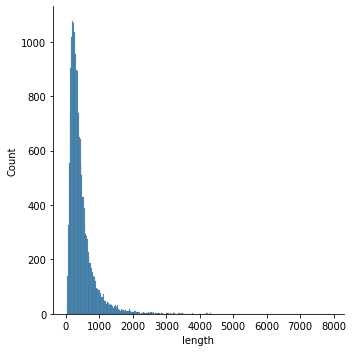

In [25]:
df.head()
df['length'] = df['reviews'].apply(len)
sns.displot(df.length)

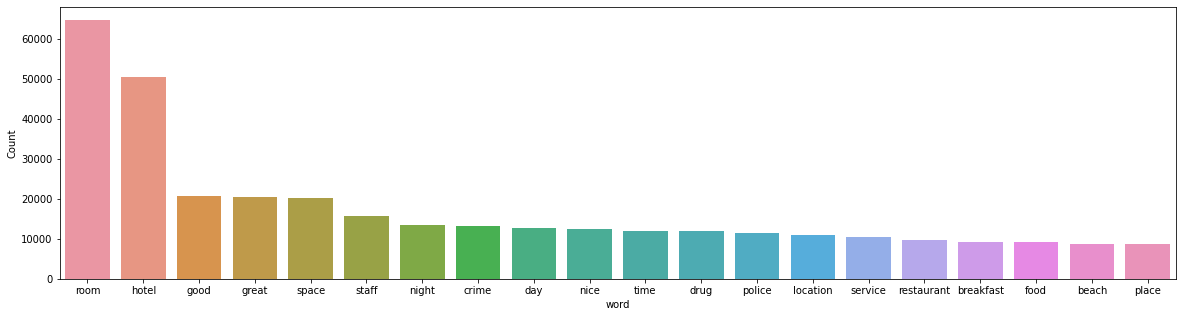

In [26]:
frequent_words(df['reviews'],20)

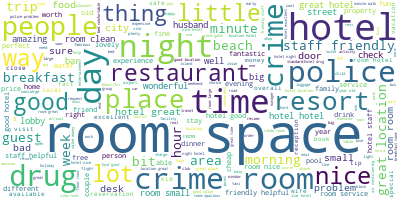

In [27]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['reviews'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [28]:
df.head()

,Review,Rating,reviews,length
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking good deal hotel a...,452
1,nothing special charge diamond member hilton d...,2,special charge diamond member chain 20th anniv...,1154
2,nice rooms not experience hotel monaco seattle...,3,nice room hotel hotel room space large bathroo...,839
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel locatio...,476
4,"great stay great stay, went seahawk game aweso...",5,great great stay awesome downfall crime room s...,816


In [29]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [30]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [31]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [32]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

In [ ]:
lda_model.print_topics()

[(0,
  '0.032*"_" + 0.020*"royal" + 0.013*"crimen__ç_é" + 0.007*"don__ç_é" + 0.006*"waitress" + 0.005*"it__ç_é" + 0.004*"soda" + 0.004*"cent" + 0.004*"you__ç_éèe" + 0.004*"royalty"'),
 (1,
  '0.009*"hyatt" + 0.008*"orchard" + 0.007*"residence" + 0.007*"glass" + 0.007*"tidy" + 0.006*"blind" + 0.006*"marble" + 0.005*"century" + 0.004*"wing" + 0.004*"disco"'),
 (2,
  '0.098*"room" + 0.034*"space" + 0.027*"hotel" + 0.023*"police" + 0.021*"crime" + 0.014*"night" + 0.011*"bed" + 0.011*"day" + 0.009*"desk" + 0.009*"floor"'),
 (3,
  '0.036*"service" + 0.029*"hotel" + 0.019*"staff" + 0.012*"guest" + 0.010*"experience" + 0.009*"club" + 0.008*"year" + 0.008*"food" + 0.007*"property" + 0.007*"restaurant"'),
 (4,
  '0.024*"car" + 0.018*"parking" + 0.017*"bus" + 0.017*"airport" + 0.015*"free" + 0.013*"taxi" + 0.011*"shuttle" + 0.010*"minute" + 0.009*"park" + 0.008*"area"'),
 (5,
  '0.073*"hotel" + 0.052*"room" + 0.027*"great" + 0.023*"good" + 0.020*"location" + 0.018*"staff" + 0.015*"breakfast" + 0.

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.232897 -0.001894       1        1  37.013661
6      0.197548  0.029810       2        1  24.577916
2      0.198171  0.056525       3        1  20.247473
3      0.099127  0.097038       4        1  10.441644
4     -0.076448 -0.342725       5        1   4.900228
0     -0.338564  0.079065       6        1   1.422900
1     -0.312730  0.082182       7        1   1.396178, topic_info=         Term          Freq         Total Category  logprob  loglift
47       room  62897.000000  62897.000000  Default  30.0000  30.0000
26      hotel  49575.000000  49575.000000  Default  29.0000  29.0000
195   service   9994.000000   9994.000000  Default  28.0000  28.0000
3549    beach   8262.000000   8262.000000  Default  27.0000  27.0000
3514   resort   7736.000000   7736.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1051    black     65.997348    291.245512   Topic7  -5.6812   2.7869
871       ice     78.249606    591.716175   Topic7  -5.5109   2.2483
1177    style     73.562689    966.201281   Topic7  -5.5727   1.6962
6        bath     64.753568   1221.858606   Topic7  -5.7002   1.3339
248       tea     56.429595    995.083373   Topic7  -5.8378   1.4016

[472 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.198873           -
0         2  0.066449           -
0         3  0.501217           -
0         4  0.189380           -
0         5  0.031326           -
...     ...       ...         ...
587       1  0.245905        year
587       2  0.280233        year
587       3  0.080538        year
587       4  0.393118        year
5044      6  0.987958  you__ç_éèe

[778 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 3, 4, 5, 1, 2])

In [34]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


# Create Dictionary
id2word = corpora.Dictionary(reviews_2)
print ("Please preview the corpora dictionary")
print (id2word)

# Create Corpus
texts = reviews_2
reviews_2[1]

Please preview the corpora dictionary
Dictionary(36544 unique tokens: ['-', 'advantage', 'advice', 'anniversary', 'aveda']...)


['special',
 'charge',
 'diamond',
 'member',
 'chain',
 '20th',
 'anniversary',
 'seattle',
 'suite',
 'extra',
 'website',
 'description',
 'bedroom',
 'bathroom',
 'standard',
 'hotel',
 'room',
 'reservation',
 'desk',
 'thing',
 'couch',
 'ect',
 'desk',
 'clerk',
 'mixed',
 'suite',
 'website',
 'free',
 'breakfast',
 'embassy',
 'suit',
 'room',
 'bathroom',
 'bedroom',
 'call',
 'suite',
 'day',
 'stay',
 'offer',
 'false',
 'advertising',
 'guest',
 'website',
 'email',
 'failure',
 'suite',
 'advertised',
 'website',
 'reservation',
 'description',
 'hard',
 'copy',
 'reservation',
 'printout',
 'website',
 'desk',
 'manager',
 'duty',
 'crime',
 'reply',
 'solution',
 'email',
 'trip',
 'guest',
 'survey',
 'crime',
 'follow',
 'email',
 'mail',
 'staff',
 'helpful',
 'desk',
 'good',
 'breakfast',
 'spot',
 'neighborhood',
 'hood',
 'police',
 'hotel',
 'good',
 'breakfast',
 'spot',
 'seattle',
 'block',
 'convenient',
 'hotel',
 'know',
 'late',
 'night',
 'run',
 'bellma

In [35]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print ("Please preview the document frequency")
print (corpus[200])

Please preview the document frequency
[(11, 1), (26, 1), (35, 1), (47, 1), (64, 1), (115, 1), (121, 1), (132, 1), (198, 1), (214, 1), (376, 1), (386, 1), (416, 1), (769, 1), (889, 1), (1151, 1), (1400, 1)]


In [37]:
# Build LDA model with 12 Topics choosing Random State as 42

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=12, 
                                       random_state=4,
                                       passes=10,
                                       per_word_topics=True)

# Build LDA model and find the ideal random state when the no of topics is 12 by running random state over 1 to 100.
maxv = 0
maxrs = 0
for rs in range(1,5):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=rs,
                                           passes=10,
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print ('Coherence Score:{} RS : {} '.format(coherence_lda,rs))
    if coherence_lda > maxv:
        maxv = coherence_lda
        maxrs = rs 
print ("The ideal coherence score {} corresponds to random state {} ".format(maxv,maxrs))

Coherence Score:0.42680251890807525 RS : 1 
Coherence Score:0.43341907765466314 RS : 2 
Coherence Score:0.42332441072991484 RS : 3 
Coherence Score:0.4015678338795065 RS : 4 
The ideal coherence score 0.43341907765466314 corresponds to random state 2 


In [44]:
topics = lda_model.show_topics(formatted=False)
topic_id = [t[0] for t in topics]
print (topic_id)
top_terms = []
for topic in topics:
    top_terms.append([term[0] for term in topic[1]])
    
topic_df = pd.DataFrame({'Topic ID': topic_id, 'Top Terms':top_terms})
topic_df=topic_df.sort_values(by=[topic_df.columns[0]])
topic_df.style.hide_index()

[1, 2, 5, 6, 4, 11, 0, 9, 3, 10]


Topic ID,Top Terms
0,"['room', 'space', 'crime', 'police', 'day', 'time', 'hotel', 'drug', 'service', 'staff']"
1,"['apartment', 'taxi', 'executive', 'hyatt', 'driver', 'bahn', 'road', 'lounge', 'min', 'bus']"
2,"['hotel', 'service', 'property', 'star', 'high', 'quality', 'business', 'rate', 'villa', 'guest']"
3,"['room', 'hotel', 'space', 'bed', 'night', 'floor', 'bathroom', 'nice', 'crime', 'police']"
4,"['breakfast', 'hotel', 'free', 'internet', 'coffee', 'room', 'good', 'day', 'minute', 'access']"
5,"['rice', 'animation', 'palace', 'pork', 'ubud', 'bean', 'golf', 'soup', 'flea', 'latin']"
6,"['hotel', 'room', 'great', 'good', 'staff', 'location', 'clean', 'excellent', 'nice', 'night']"
9,"['pool', 'area', 'beach', 'restaurant', 'food', 'bar', '_', 'nice', 'spa', 'club']"
10,"['resort', 'beach', 'good', 'food', 'pool', 'water', 'great', 'nice', 'bar', 'people']"
11,"['great', 'time', 'staff', 'food', 'day', 'service', 'drug', 'good', 'amazing', 'wonderful']"


In [49]:
topics = lda_model.show_topics(formatted=False)
topics[0]

(7,
 [('florence', 0.02062972),
  ('terrace', 0.010266499),
  ('mate', 0.008745587),
  ('ponte', 0.007344755),
  ('elegant', 0.006409),
  ('barcelona', 0.006161775),
  ('street', 0.0049961046),
  ('gay', 0.004860801),
  ('eiffel', 0.004691986),
  ('rambla', 0.0046285116)])

In [50]:
maxrs = [39,22]
no_t = [6,12]
coherence_lda = [0.622733, 0.565889]
result_df = pd.DataFrame({'No of topics': no_t, 'Best Random State': maxrs , 'Coherence Score': coherence_lda})
result_df.style.hide_index()
result_df

,No of topics,Best Random State,Coherence Score
0,6,39,0.622733
1,12,22,0.565889
